# Preprocessing a larger sample

### Get subset of full dataset

First we import the necessary libraries

In [4]:
import csv
import pandas as pd
import regex as re
import gc
import numpy as np
import random
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time

We define a function to load a subset of the articles

In [5]:
#Indhenter et sample på ca. 1,45M artikler, meget tidseffektivt
def getSample(csvstring: str, sample_size: int):
    random.seed(0)
    n = 11000000 #number of records in file (excludes header)
    s = sample_size #desired sample size
    skip = sorted(random.sample(range(1,n+1),n-s))
    # Read the CSV file, skipping the randomly selected rows
    sampled_data = pd.read_csv(csvstring, on_bad_lines='skip', skiprows=skip, index_col=0)
    sampled_data = sampled_data.reset_index()
    return sampled_data

In [6]:
data = getSample("data/news_cleaned_2018_02_13-1.csv",5000)

In [7]:
len(data)

3905

### Inspecting The Sample

In [8]:
def get_type_freq(dataframe):
    typedict = {}
    for i in dataframe['type']: 
        if str(i) in typedict:
            typedict[str(i)] +=1 
        else: 
            typedict[str(i)] =1 
    typedict
    typedictperc = typedict.copy()
    #laver et nyt dictionairy som viser det i procenttal
    for i in typedictperc:
        typedictperc[i] = (typedictperc[i]/(len(data)))*100
    return typedictperc

In [9]:
get_type_freq(data)

{'fake': 10.345710627400768,
 'conspiracy': 9.807938540332907,
 'political': 18.56594110115237,
 'bias': 13.4955185659411,
 'clickbait': 2.9193341869398206,
 'nan': 5.172855313700384,
 'unreliable': 3.6619718309859155,
 'rumor': 5.761843790012804,
 'junksci': 1.3060179257362354,
 'unknown': 4.12291933418694,
 'reliable': 22.458386683738794,
 'hate': 1.1011523687580027,
 'satire': 1.2804097311139564}

In [10]:
allArticlesCount = 928083 + 146080 + 1300444 + 905981 + 144939 + 117374 + 292201 + 2435471 + 319830 + 1920139
#Jeg henter data from README.md om hvor mange artikler af hver type, der er i det fulde datasæt
realtypeperc = {"reliable": (1920139/allArticlesCount)*100, "political": (2435471/allArticlesCount)*100, "bias": (1300444/allArticlesCount)*100, "Satire": (146080/allArticlesCount)*100, "fake": (928083/allArticlesCount)*100, "conspiracy":(905981/allArticlesCount)*100, "unreliable": (319830/allArticlesCount)*100, "clickbait":(292201/allArticlesCount)*100, "junksci":(144939/allArticlesCount)*100 , "hate":(117374/allArticlesCount)*100}
realtypeperc
#jeg præsenterer det som procenter
#ved sammenligning er det tydeligt, at Mikkels forkortede datasæt ikke har markant anderledes proportion ift. artikeltyper, end det fulde datasæt
#Største forskel er at der er tilføjet nye typer af artikler som rumor til datasættet, siden README blev skrevet. 
#Vi kan bruge dette til at forsikre os selv om at vores forkortede datasæt er repræsentativt for det fulde datasæt. 

{'reliable': 22.561888537768805,
 'political': 28.617108052577617,
 'bias': 15.280389897611691,
 'Satire': 1.716459421738357,
 'fake': 10.905098641191126,
 'conspiracy': 10.645397202669349,
 'unreliable': 3.7580450222794273,
 'clickbait': 3.4334005989277774,
 'junksci': 1.703052520039264,
 'hate': 1.3791601051965903}

### Structure Sample For Preprocessing

Before we preprocess there are some articles we can remove from the data set. We also change the labels so that
they are either 'reliable' or 'fake'

In [11]:
#Klassificerer alt som reliable/fake
def binary_labels(df): 
    #klassificerer alle de artikler vi vil bruge ind i reliable eller fake
    df.type = df.type.replace({'political': 'reliable', 'junksci': 'fake', 'bias' : 'fake', 'satire': 'fake', 'conspiracy': 'fake', 'rumor': 'fake', 'unreliable' : 'fake', 'clickbait': 'fake', 'hate': 'fake'})
    return df

In [12]:
data = binary_labels(data)

In [13]:
#Fjerner alle de artikler vi ikke skal bruges. NB: SKAL kaldes på en dataframe, som allerede har været igennem binary_labels
def remove_bad_articles(df): 
    #fjerner artikler som har volapyk types (inklusiv 'unknown')
    df = df[(df.type == 'reliable') |(df.type == 'fake')]
    #fjerner artikler som ikke har nogen type
    df = df[df.type.notnull()]
    #fjerner artikler uden content
    df = df[df.content.notnull()]
    #fjerner duplerede artikler, ud over en enkelt
    df = df.drop_duplicates(subset = 'content', keep = 'last')
    #fjerner de artikler som ikke indeholder mindst et latinsk bogstav
    df = df[df.content.str.contains('[a-z]')]
    #reset index gør, at hvis vi fjerner artikle [2], bliver artikel [3] rykket ned på index [2] osv. dernedad.
    df = df.reset_index().drop(columns='index').rename(columns={'level_0':'index'})
    return df 

In [14]:
data = remove_bad_articles(data)

In [15]:
data_length = len(data)

In [16]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [17]:
labelperc(data)

{'fake': 52.60770975056689, 'reliable': 47.3922902494331}

In [18]:
temp = "data/sample_structured.csv"

In [19]:
data.to_csv(temp, index=False)

In [20]:
# free memory
del data
gc.collect()

784

### Cleaning and preprocessing

Then, we preprocess the sample

In [77]:
from datetime import datetime
from ipywidgets import IntProgress
from IPython.display import display
import pandas as pd
import csv
import time
import itertools
import nltk

In [29]:
# RegEx patterns, catches expressions as var-names imply.
mail_pattern = re.compile(r"(?P<Mails>[w\.-]+@[\w\.-]+\.[\w]+)")
url_pattern = re.compile(r"(?P<URL>(?:(?:https?|ftp):[/][/])?[\w/\-?=%.]+\.[\w/\-&?=%.]+)")
date_pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
num_pattern = re.compile(r"[a-zA-Z]*\d+[a-zA-Z]*") 
#punct_remove = re.compile(r"[a-zA-Z]*[^a-zA-Z\s]+[a-zA-Z]*")
punct_remove = re.compile(r"[^a-zA-Z\s]+")
white_space = re.compile(r"[\s]+|\n+")

def clean_single_string(st):
    s1 = st.lower()
    s2 = mail_pattern.sub(" mail ", s1)
    s3 = url_pattern.sub(" url ", s2)
    s4 = date_pattern.sub(" date ", s3)
    s5 = num_pattern.sub(" num ", s4)
    s6 = punct_remove.sub(" ", s5)
    s7 = white_space.sub(" ", s6)
    return s7

In [32]:
def stopwords_remover():
    stop = stopwords.words('english')
    def remove_stopwords(tokenlist):
        return list(filter(lambda x : x not in stop, tokenlist))
    return remove_stopwords

In [33]:
def token_stemmer():
    stemmer = PorterStemmer()
    def stem_tokenlist(tokenlist):
        return [stemmer.stem(token) for token in tokenlist]
    return stem_tokenlist

In [34]:
def tokenizer():
    def tokenize(str):
        return nltk.word_tokenize(str)
    return tokenize

In [75]:
#For Windows systems
#import os
#file_name = os.path.join("data/sample_preprocessed_ver_" + datetime.today().strftime('%Y-%m-%d-%H%M%S') + ".csv")
#meta_data = os.path.join("meta_data/preprocess_info_" + datetime.today().strftime('%Y-%m-%d-%H%M%S') + ".csv")

In [78]:
#For Unix systems
file_name = "data/sample_preprocessed_ver_" + datetime.today().strftime('%Y-%m-%d-%s') + ".csv"
meta_data = "meta_data/preprocess_info_" + datetime.today().strftime('%Y-%m-%d-%s') + "csv"

In [28]:
f = IntProgress(min=0, max=data_length)
display(f)
CHUNK_SIZE = 10000
for chunk in pd.read_csv(temp, chunksize=CHUNK_SIZE, index_col=0):
    chunk['content'] = chunk['content'].apply(clean_single_string) # clean chunk
    chunk['content'] = chunk['content'].apply(tokenizer()) # tokenize    
    chunk['content'] = chunk['content'].apply(stopwords_remover()) # remove stopwords
    chunk['content'] = chunk['content'].apply(token_stemmer()) # stem tokens
    chunk.to_csv(file_name, mode="a", index=False)

    f.value += CHUNK_SIZE


IntProgress(value=0, max=3087)

# Models

### Loading preprocessed dataset for model training


In [2]:
import pandas as pd
import regex as re
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns
from joblib import dump, load

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from ipywidgets import IntProgress
from IPython.display import display

In [3]:
data = pd.read_csv(file_name, index_col=0)

In [4]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)

In [5]:
data['content'] = data['content'].apply(string_to_list)

In [6]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [7]:
labelperc(data)

{'fake': 51.38139873707058,
 'reliable': 48.60865913170815,
 'type': 0.009942131221265383}

In [8]:
data = data[(data.type == 'reliable') |(data.type == 'fake')]

In [9]:
len(data)

1076121

## Simple Model - Logistic Regression

### Training

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x36232bf60>,
                max_features=200000)

In [12]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zzyzx', 'zzz', 'zzzz'], dtype=object)

In [13]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [14]:
logreg = LogisticRegression(solver='sag')
logreg.fit(X_train, y_train)

/Users/mikkelkjaerulf/miniconda3/envs/fn_test_1/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [15]:
pred = logreg.predict(X_val)

In [16]:
accuracy_score(y_val, pred)

0.7725346615619076

In [17]:
precision_score(y_val, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7863477725313077

In [18]:
recall_score(y_val, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7313361591629435

In [19]:
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7578449606268055

[[44831 10407]
 [14071 38303]]


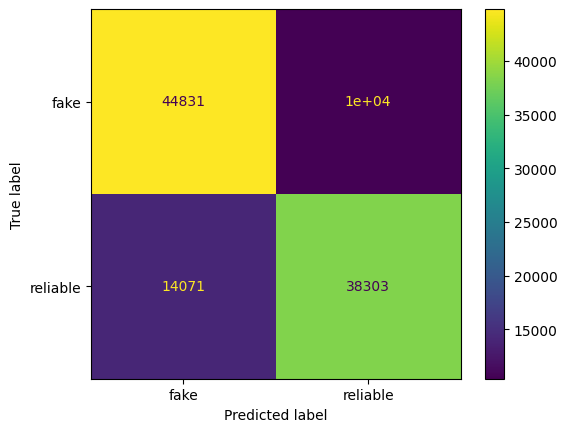

In [20]:
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()

### Evaluation

Evaluating on the Fake News Corpus test data

In [21]:
pred = logreg.predict(X_test)

In [22]:
accuracy_score(y_test, pred)

0.774172265432615

In [23]:
precision_score(y_test, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7867017909289551

In [24]:
recall_score(y_test, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7354575132204425

In [25]:
f1_score(pd.Series.to_numpy(y_test), pred, pos_label='reliable')

0.7602170695609276

[[44787 10445]
 [13857 38524]]


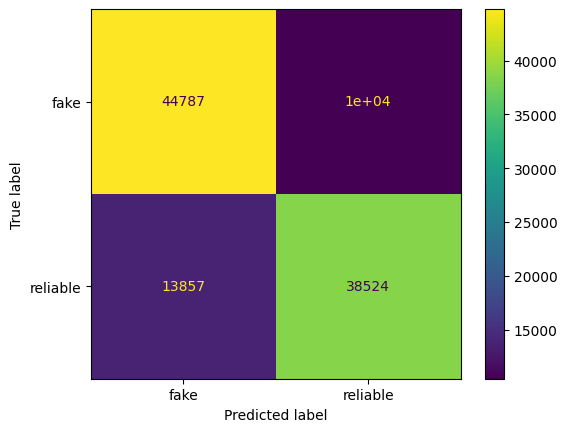

In [26]:
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_test), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()

Evaluating on the LIAR dataset

In [27]:
liar1_data = pd.read_table("liar/test.tsv", index_col=0)
liar2_data = pd.read_table("liar/train.tsv", index_col=0)
liar3_data = pd.read_table("liar/valid.tsv", index_col=0)

liar1_data.columns = ['type', 'content', 'subject', 'source', 'author', 'geography', 'political affiliation', 'number1', 'number2', 'number3', 'number4', 'number5', ' context']
liar2_data.columns = ['type', 'content', 'subject', 'source', 'author', 'geography', 'political affiliation', 'number1', 'number2', 'number3', 'number4', 'number5', ' context']
liar3_data.columns = ['type', 'content', 'subject', 'source', 'author', 'geography', 'political affiliation', 'number1', 'number2', 'number3', 'number4', 'number5', ' context']

liar_data = liar1_data.append(liar2_data).append(liar3_data)

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_20400/659257930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  liar_data = liar1_data.append(liar2_data).append(liar3_data)
/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_20400/659257930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  liar_data = liar1_data.append(liar2_data).append(liar3_data)


Apply our preprocessing pipeline to the liar dataset

In [30]:
liar_data['content'] = liar_data['content'].apply(clean_single_string)

In [35]:
liar_data['content'] = liar_data['content'].apply(tokenizer()) # tokenize    
#vocab = set(itertools.chain.from_iterable(liar_data['content'])) # get vocabulary
liar_data['content'] = liar_data['content'].apply(stopwords_remover()) # remove stopwords
#vocab_no_stopwords = set(itertools.chain.from_iterable(liar_data['content'])) # get vocabulary
liar_data['content'] = liar_data['content'].apply(token_stemmer())

In [36]:
liar_data.type = liar_data.type.replace({'half-true': 'fake', 'mostly-true': 'reliable', 'false' : 'fake', 'true': 'reliable', 'barely-true':'fake', 'pants-fire': 'fake'})

In [37]:
liar_data.head()

,type,content,subject,source,author,geography,political affiliation,number1,number2,number3,number4,number5,context
11685.json,fake,"[wisconsin, pace, doubl, number, layoff, year]",jobs,katrina-shankland,State representative,Wisconsin,democrat,2.0,1.0,0.0,0.0,0.0,a news conference
11096.json,fake,"[say, john, mccain, done, noth, help, vet]","military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,comments on ABC's This Week.
5209.json,fake,"[suzann, bonamici, support, plan, cut, choic, ...","medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1.0,1.0,3.0,1.0,1.0,a radio show
9524.json,fake,"[ask, report, whether, he, center, crimin, sch...","campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5.0,7.0,2.0,2.0,7.0,a web video
5962.json,reliable,"[past, five, year, feder, govern, paid, num, m...","federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1.0,2.0,1.0,1.0,0.0,a campaign website


In [38]:
liar_data_logreg = vectorizer.transform(liar_data['content'])

In [39]:
pred = logreg.predict(liar_data_logreg)

In [40]:
accuracy_score(liar_data['type'], pred)

0.4762277134813888

In [41]:
precision_score(liar_data['type'], pred, labels=['reliable', 'fake'], pos_label='reliable')

0.36782440906898217

In [42]:
recall_score(liar_data['type'], pred, labels=['reliable', 'fake'], pos_label='reliable')

0.6768752774079005

In [43]:
f1_score(pd.Series.to_numpy(liar_data['type']), pred, pos_label='reliable')

0.4766369745272699

[[3040 5242]
 [1456 3050]]


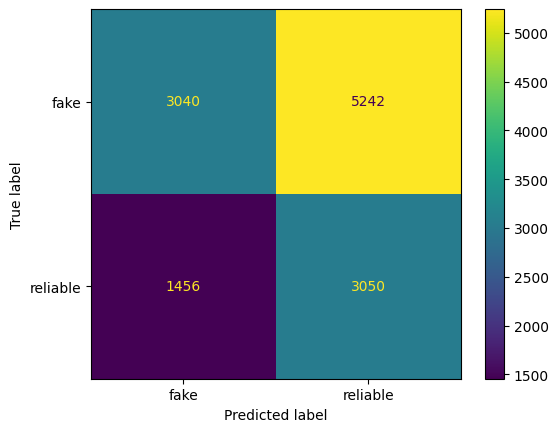

In [44]:
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(liar_data['type']), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()

## Advanced Model - Naive Bayes

### Training

In [45]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=200000, sublinear_tf=True)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x3105eee80>,
                max_features=200000, sublinear_tf=True)

In [47]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [48]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zzyzx', 'zzz', 'zzzz'], dtype=object)

In [49]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.5, force_alpha=True)
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.5, force_alpha=True)

In [50]:
pred = nb.predict(X_val)

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.8121306174032635

In [52]:
precision_score(y_val, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.8143586134084111

In [53]:
recall_score(y_val, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7952801008133806

In [54]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.8047062914770915

[[45743  9495]
 [10722 41652]]


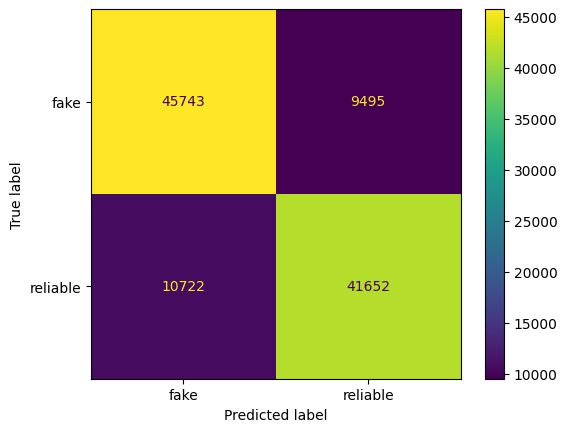

In [55]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()

### Evaluation

Evaluating on the Fake News Corpus

In [71]:
pred = nb.predict(X_test)

In [72]:
accuracy_score(y_test, pred)

0.8129686933734772

In [73]:
precision_score(y_test, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.8154733959311424

In [74]:
recall_score(y_test, pred, labels=['reliable', 'fake'], pos_label='reliable')

0.7958420037799966

In [59]:
f1_score(pd.Series.to_numpy(y_test), pred, pos_label='reliable')

0.8055381107428913

[[45799  9433]
 [10694 41687]]


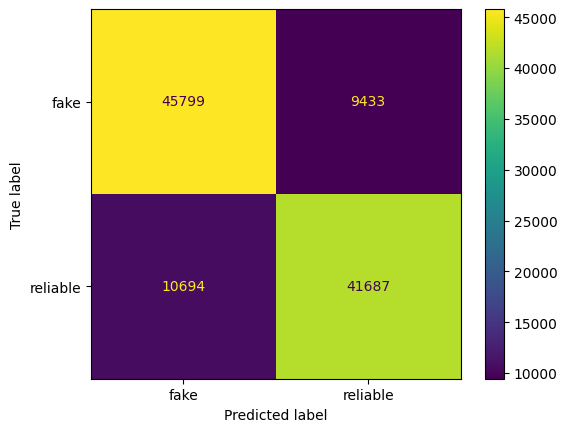

In [60]:
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_test), pred, labels=nb.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()

Evaluating on the LIAR dataset

In [61]:
liar_data_nb = vectorizer.transform(liar_data['content'])

In [62]:
pred = logreg.predict(liar_data_logreg)

In [63]:
accuracy_score(liar_data['type'], pred)

0.4762277134813888

In [64]:
precision_score(liar_data['type'], pred, labels=['reliable', 'fake'], pos_label='reliable')

0.36782440906898217

In [65]:
recall_score(liar_data['type'], pred, labels=['reliable', 'fake'], pos_label='reliable')

0.6768752774079005

In [66]:
f1_score(pd.Series.to_numpy(liar_data['type']), pred, pos_label='reliable')

0.4766369745272699

[[3040 5242]
 [1456 3050]]


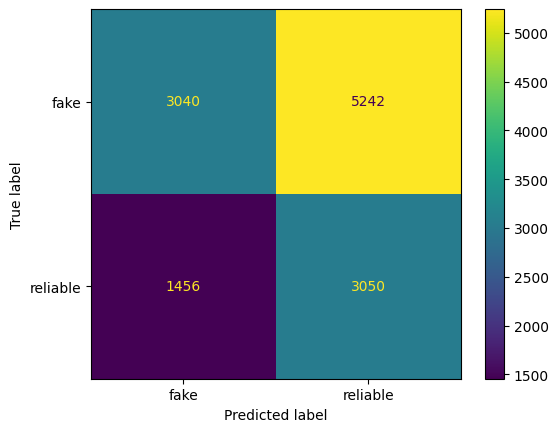

In [67]:
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(liar_data['type']), pred, labels=nb.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()